<a href="https://colab.research.google.com/github/simonopravil/nn_to_al-/blob/main/02_labels_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!pip install rioxarray

In [ ]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import rioxarray
import rasterio
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def xr_rasterize(gdf,
                 da,
                 attribute_col=False,
                 crs=None,
                 transform=None,
                 name=None,
                 x_dim='x',
                 y_dim='y',
                 export_tiff=None,
                 verbose=False,
                 **rasterio_kwargs):    
    """
    Rasterizes a geopandas.GeoDataFrame into an xarray.DataArray.
    
    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        A geopandas.GeoDataFrame object containing the vector/shapefile
        data you want to rasterise.
    da : xarray.DataArray or xarray.Dataset
        The shape, coordinates, dimensions, and transform of this object 
        are used to build the rasterized shapefile. It effectively 
        provides a template. The attributes of this object are also 
        appended to the output xarray.DataArray.
    attribute_col : string, optional
        Name of the attribute column in the geodataframe that the pixels 
        in the raster will contain.  If set to False, output will be a 
        boolean array of 1's and 0's.
    crs : str, optional
        CRS metadata to add to the output xarray. e.g. 'epsg:3577'.
        The function will attempt get this info from the input 
        GeoDataFrame first.
    transform : affine.Affine object, optional
        An affine.Affine object (e.g. `from affine import Affine; 
        Affine(30.0, 0.0, 548040.0, 0.0, -30.0, "6886890.0) giving the 
        affine transformation used to convert raster coordinates 
        (e.g. [0, 0]) to geographic coordinates. If none is provided, 
        the function will attempt to obtain an affine transformation 
        from the xarray object (e.g. either at `da.transform` or
        `da.geobox.transform`).
    x_dim : str, optional
        An optional string allowing you to override the xarray dimension 
        used for x coordinates. Defaults to 'x'. Useful, for example, 
        if x and y dims instead called 'lat' and 'lon'.   
    y_dim : str, optional
        An optional string allowing you to override the xarray dimension 
        used for y coordinates. Defaults to 'y'. Useful, for example, 
        if x and y dims instead called 'lat' and 'lon'.
    export_tiff: str, optional
        If a filepath is provided (e.g 'output/output.tif'), will export a
        geotiff file. A named array is required for this operation, if one
        is not supplied by the user a default name, 'data', is used
    verbose : bool, optional
        Print debugging messages. Default False.
    **rasterio_kwargs : 
        A set of keyword arguments to rasterio.features.rasterize
        Can include: 'all_touched', 'merge_alg', 'dtype'.
    
    Returns
    -------
    xarr : xarray.DataArray
    
    """
    
    # Check for a crs object
    try:
        crs = da.rio.crs
    except:
        if crs is None:
            raise ValueError("Please add a `crs` attribute to the "
                                 "xarray.DataArray, or provide a CRS using the "
                                 "function's `crs` parameter (e.g. crs='EPSG:3577')")
    
    # Check if transform is provided as a xarray.DataArray method.
    # If not, require supplied Affine
    if transform is None:
        try:
            # First, try to take transform info from rioxarray
            transform = da.rio.transform()
        # If no rioxarray
        except:
            try:
                # Try getting transform from 'transform' attribute
                transform = da.transform
            except:
                # If neither of those options work, raise an exception telling the 
                # user to provide a transform
                raise TypeError("Please provide an Affine transform object using the "
                                "`transform` parameter (e.g. `from affine import "
                                "Affine; Affine(30.0, 0.0, 548040.0, 0.0, -30.0, "
                                "6886890.0)`")
    
    # Grab the 2D dims (not time)    

    dims = y_dim, x_dim  
    
    # Coords
    xy_coords = [da[dims[0]], da[dims[1]]]
    
    # Shape
    try:
        y, x = da.shape
    except:
        y, x = len(xy_coords[0]), len(xy_coords[1])
    
    
    # If an attribute column is specified, rasterise using vector 
    # attribute values. Otherwise, rasterise into a boolean array
    if attribute_col:        
        # Use the geometry and attributes from `gdf` to create an iterable
        shapes = zip(gdf.geometry, gdf[attribute_col])
    else:
        # Use geometry directly (will produce a boolean numpy array)
        shapes = gdf.geometry


    # Rasterise shapes into an array
    arr = rasterio.features.rasterize(shapes=shapes,
                                      out_shape=(y, x),
                                      transform=transform,
                                      **rasterio_kwargs)
        
    # Convert result to a xarray.DataArray
    xarr = xr.DataArray(arr,
                        coords=xy_coords,
                        dims=dims,
                        name=name if name else None)
    
    # Add back crs if xarr.attrs doesn't have it
    if xarr.rio.crs is None:
        xarr = xarr.rio.write_crs(str(crs))
    
    if export_tiff: 
        if verbose:
            print(f"Exporting GeoTIFF to {export_tiff}")
        xarr.rio.to_raster(raster_path=export_tiff, driver = 'cog')
                
    return xarr

In [ ]:
# Read vector
gf = gpd.read_file("/content/drive/MyDrive/PhD/Projects/CroplandGrasslands/SHP/Tat_CG.shp")
gf = gf[['KODKD', 'kultura', 'layer', 'geometry']]
gf['layer'] = gf['layer'].astype(np.int16)
gf['agri'] = 1

In [ ]:
filtered_gf = gf[gf['layer'] == 4]
filtered_gf = filtered_gf.to_crs(4326)

In [ ]:
path = "/content/drive/MyDrive/PhD/Projects/CroplandGrasslands/tiff/s2cnn4.tif"
da = xr.open_dataarray(path)
da.rio.set_crs(4326, inplace = True)

<xarray.DataArray 'band_data' (band: 4, y: 2254, x: 4345)>
[39174520 values with dtype=float64]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 21.69 21.69 21.69 21.69 ... 22.08 22.08 22.08 22.08
  * y            (y) float64 49.37 49.37 49.37 49.37 ... 49.17 49.17 49.17 49.17
    spatial_ref  int64 ...
Attributes:
    long_name:  ('B2', 'B3', 'B4', 'B8')

In [ ]:
zone = xr_rasterize(filtered_gf,
                 da,
                 attribute_col='agri',
                 crs=32634,
                 transform=None,
                 name=None,
                 x_dim='x',
                 y_dim='y',
                 export_tiff="/content/drive/MyDrive/PhD/Projects/CroplandGrasslands/tiff/label4.tif",
                 verbose=True)

Exporting GeoTIFF to /content/drive/MyDrive/PhD/Projects/CroplandGrasslands/tiff/label4.tif


<BarContainer object of 2 artists>

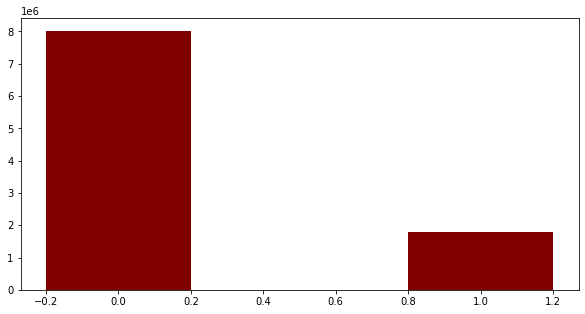

In [ ]:
val, count = np.unique(zone, return_counts=True)
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(val, count, color ='maroon', width = 0.4)

In [ ]:
val

array([0], dtype=uint8)